# **Mountung Drive & Doing Nessecary Installations**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! git clone https://github.com/apple/ml-mkqa.git

Cloning into 'ml-mkqa'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 65 (delta 17), reused 56 (delta 9), pack-reused 0
Unpacking objects: 100% (65/65), 12.41 MiB | 13.00 MiB/s, done.


In [ ]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## **Importing Dependencies & Reading the Data**

In [ ]:
import pandas as pd
import re
import nltk
import random
import tensorflow as tf
import io
import re
import string
import tqdm
import numpy as np
import keras.backend as K
import plotly.graph_objs as go
from tensorflow.keras import layers
from keras.layers.core import Dense, Reshape
from keras.models import Model,Sequential 
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import euclidean_distances
from keras.preprocessing.sequence import skipgrams 
from IPython.display import display_svg , SVG
from keras.utils.vis_utils import model_to_dot
from keras.layers import *
from keras.preprocessing import text
from string import punctuation
from nltk.corpus import PlaintextCorpusReader
from tqdm import tqdm
from sklearn.manifold import TSNE
from keras.utils import pad_sequences
from keras.utils import np_utils
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('arabic')
stop_words_ar = set(stopwords.words('arabic'))
stop_words = nltk.corpus.stopwords.words('english') 


[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading arabic: Package 'arabic' not found in index


**Reading The Data**

In [ ]:
df = pd.read_json('/content/ml-mkqa/dataset/mkqa.jsonl.gz',lines=True)

In [ ]:
df.head()

,query,answers,queries,example_id
0,how long did it take the twin towers to be built,"{'en': [{'type': 'number_with_unit', 'text': '...",{'tr': 'ikiz kulelerin inşa edilmesi ne kadar ...,3051930912491995402
1,where did the phrase great scott come from,"{'en': [{'type': 'long_answer', 'text': None}]...",{'tr': 'büyük scott deyimi nerede ortaya çıkmı...,6277735658261425592
2,who sings love you like there's no tomorrow,"{'en': [{'type': 'entity', 'entity': 'Q952176'...",{'tr': 'love you like there's no tomorrow'u ki...,-4766029169354683727
3,how many seasons of scream queens are there,"{'en': [{'type': 'number', 'text': '2.0', 'ali...",{'tr': 'Scream Queens dizisi kaç sezondan oluş...,-5007314435785513023
4,when was the last time the lakers made the pla...,"{'en': [{'type': 'date', 'text': '2013', 'alia...",{'tr': 'lakers'ın play-off yaptığı son zaman n...,7960403399608384663


## Get the Arabic and English corpora

**Getting both Arabic and english texts from the "Answers" and "Questions"**

In [ ]:
df['arabic']=df['queries'].apply(lambda x:x['ar'])
df['arabicAns']=df['answers'].apply(lambda x:x['ar'])
df['arabicAns']=df['arabicAns'].apply(lambda x:x[0].get('text'))
df['englishAns']=df['answers'].apply(lambda x:x['en'])
df['englishAns']=df['englishAns'].apply(lambda x:x[0].get('text'))

In [ ]:
df.head()

,query,answers,queries,example_id,arabic,arabicAns,englishAns
0,how long did it take the twin towers to be built,"{'en': [{'type': 'number_with_unit', 'text': '...",{'tr': 'ikiz kulelerin inşa edilmesi ne kadar ...,3051930912491995402,: كم من الوقت استغرق بناء البرجين التوأمين,11.0 سنة,11.0 years
1,where did the phrase great scott come from,"{'en': [{'type': 'long_answer', 'text': None}]...",{'tr': 'büyük scott deyimi nerede ortaya çıkmı...,6277735658261425592,"من أين جاءت العبارة ""great scott""",None,None
2,who sings love you like there's no tomorrow,"{'en': [{'type': 'entity', 'entity': 'Q952176'...",{'tr': 'love you like there's no tomorrow'u ki...,-4766029169354683727,من الذي يغني أحبك مثل لا يوجد غدا,كريس يونغ,Chris Young
3,how many seasons of scream queens are there,"{'en': [{'type': 'number', 'text': '2.0', 'ali...",{'tr': 'Scream Queens dizisi kaç sezondan oluş...,-5007314435785513023,كم عدد مواسم ملكات الصراخ,2.0,2.0
4,when was the last time the lakers made the pla...,"{'en': [{'type': 'date', 'text': '2013', 'alia...",{'tr': 'lakers'ın play-off yaptığı son zaman n...,7960403399608384663,متى كانت اخر مرة خاض فريق الليكرز المباريات ال...,2013,2013


# Cleaning the data

**Concatenating the "Answers" and the "Questions" of both languages**

In [ ]:
df = df.drop(columns=['example_id','answers','queries'])

In [ ]:
df=df.dropna()

In [ ]:
df=df.drop_duplicates()

In [ ]:
dfQ = df.iloc[:,:-2]

In [ ]:
dfQ

,query,arabic
0,how long did it take the twin towers to be built,: كم من الوقت استغرق بناء البرجين التوأمين
2,who sings love you like there's no tomorrow,من الذي يغني أحبك مثل لا يوجد غدا
3,how many seasons of scream queens are there,كم عدد مواسم ملكات الصراخ
4,when was the last time the lakers made the pla...,متى كانت اخر مرة خاض فريق الليكرز المباريات ال...
5,how many episodes in a season of stranger things,كم عدد الحلقات في جزء من مسلسل سرينجر ثينجز
...,...,...
9988,what type of government did japan have during ww2,فما هو نوع الحكومة التي كانت اليابان تتمتع بها...
9993,who sings for sally in nightmare before christmas,for sally in nightmare before christmas من الل...
9995,population of which indian state reduced in 2011,عدد سكان أي ولايه هندية خفضت في عام 2011
9997,who plays bee in whered you go bernadette,من الذي يؤدي دور بي في فلم ويرد يو جو برناديت


In [ ]:
dfA = df.iloc[:,2:]
dfA = dfA.reindex(columns = ['englishAns','arabicAns'])
dfA

,englishAns,arabicAns
0,11.0 years,11.0 سنة
2,Chris Young,كريس يونغ
3,2.0,2.0
4,2013,2013
5,3.0,3.0
...,...,...
9988,monarchy,ملكية
9993,Catherine O'Hara,كاثرين أوهارا
9995,Nagaland,ناجالاند
9997,emma nelson,إيما نيلسون


In [ ]:
dfA = dfA.rename(columns={'englishAns':'query',"arabicAns":'arabic'})
dfA

,query,arabic
0,11.0 years,11.0 سنة
2,Chris Young,كريس يونغ
3,2.0,2.0
4,2013,2013
5,3.0,3.0
...,...,...
9988,monarchy,ملكية
9993,Catherine O'Hara,كاثرين أوهارا
9995,Nagaland,ناجالاند
9997,emma nelson,إيما نيلسون


In [ ]:
COMB= pd.concat([ dfA,dfQ], ignore_index = True, axis=0)
COMB

,query,arabic
0,11.0 years,11.0 سنة
1,Chris Young,كريس يونغ
2,2.0,2.0
3,2013,2013
4,3.0,3.0
...,...,...
13511,what type of government did japan have during ww2,فما هو نوع الحكومة التي كانت اليابان تتمتع بها...
13512,who sings for sally in nightmare before christmas,for sally in nightmare before christmas من الل...
13513,population of which indian state reduced in 2011,عدد سكان أي ولايه هندية خفضت في عام 2011
13514,who plays bee in whered you go bernadette,من الذي يؤدي دور بي في فلم ويرد يو جو برناديت


In [ ]:
df = COMB

In [ ]:
df = df.rename(columns={'query':'English',"arabic":'Arabic'})

In [ ]:
# define regex pattern to match only numbers
pattern = '^[0-9]*\.?[0-9]+$'

for index, row in df.iterrows():
    matches = re.findall(pattern, row['Arabic'])
    if matches:
        df = df.drop(index)

In [ ]:
en_pattern = re.compile(r'[a-zA-Z]+')

#Filter out rows with English words in the 'text' column
df = df[~df['Arabic'].str.contains(en_pattern)]


In [ ]:
pattern = '\d{4}-\d{2}-\d{2}'

# Applying a regex pattern to each row in the dataframe to remove dates
for index, row in df.iterrows():
    matches = re.findall(pattern, row['Arabic'])
    if matches:
        df = df.drop(index)

In [ ]:
num_special_pattern = re.compile(r'^[\d\W]+$')
#Sanity check on special characters in arabic
df = df[~df['Arabic'].str.match(num_special_pattern)]

**New datframe after cleaning , but we still need to drop rows with with texts that are less than 5 words**

In [ ]:
df

,English,Arabic
0,11.0 years,11.0 سنة
1,Chris Young,كريس يونغ
5,Dave Edmunds,ديف إدموندز
6,John de Mol,جون دي مول
10,Fleetwood Mac,فليتوود ماك
...,...,...
13510,what was the number one song in june 1994,ما هي الأغنية رقم واحد في يونيو 1994
13511,what type of government did japan have during ww2,فما هو نوع الحكومة التي كانت اليابان تتمتع بها...
13513,population of which indian state reduced in 2011,عدد سكان أي ولايه هندية خفضت في عام 2011
13514,who plays bee in whered you go bernadette,من الذي يؤدي دور بي في فلم ويرد يو جو برناديت


In [ ]:
for index, row in df.iterrows():
    #lowercase english column
    text = row['English']
    text_lower = text.lower()
    df.at[index, 'English'] = text_lower

print(df)

                                                 English  \
0                                             11.0 years   
1                                            chris young   
5                                           dave edmunds   
6                                            john de mol   
10                                         fleetwood mac   
...                                                  ...   
13510          what was the number one song in june 1994   
13511  what type of government did japan have during ww2   
13513   population of which indian state reduced in 2011   
13514          who plays bee in whered you go bernadette   
13515            who plays nancy arbuckle in grown ups 2   

                                                  Arabic  
0                                               11.0 سنة  
1                                              كريس يونغ  
5                                            ديف إدموندز  
6                                          

**Removing puncituation in both languages**

In [ ]:
df["Arabic"]=df["Arabic"].str.replace(r'[^\w\s]', '', regex=True)

In [ ]:
df["English"]=df["English"].str.replace(r'[^\w\s]', '', regex=True)

In [ ]:
df.head()

,English,Arabic
0,110 years,110 سنة
1,chris young,كريس يونغ
5,dave edmunds,ديف إدموندز
6,john de mol,جون دي مول
10,fleetwood mac,فليتوود ماك


**Removing answers with less than 5 words**

In [ ]:
df = df[df['Arabic'].apply(lambda x: len(x.split()) >= 5)]

In [ ]:
df = df[df['English'].apply(lambda x: len(x.split()) >= 5)]


In [ ]:
df.head(500)

,English,Arabic
88,kc and the sunshine band,كيه سي آند فرقة الشمس
120,with our king and queen through india,مع ملكنا وملكتنا عبر الهند
615,phoenix sky harbor international airport,مطار فينيكس سكاي هاربر الدولي
628,paget brewster prentiss returned for a guest a...,عادت باجت بريوستر لظهور ضيف عام 2014 وحلقة الم...
1027,dancing with the stars season 21,الرقص مع النجوم الموسم 21
...,...,...
7298,who is the actor who plays doctor strange,من قام بدور الطبيب فى فيلم دكتور سترونج
7299,whos the coach of the cleveland cavaliers,من هو مدرب كليفلاند كافالييرز
7300,when did the rams win the super bowl,متى ربح الرامز السوبر باول
7301,who established the first private orphanage in...,من الذى أسس اول دار خاص للايتام فى مدينة نيويورك


**Saving the preprocessed data as a comma seprated values file**

In [ ]:
df.to_csv('Train.csv', index=False)

# Skip Gram: English Embeddings #

In [ ]:
df = pd.read_csv('Train.csv')

In [ ]:
skip_gram_eng = df['English'].tolist()
len(skip_gram_eng)

5463

**Creating a txt file of the english corpus so it can be better processed by the models , we will do the same for arabic and use the same file also for training CBOW**

In [ ]:
with open("skip_gram_eng.txt", "w") as file:
    for sentence in skip_gram_eng:
        file.write(sentence + "\n")

In [ ]:
corpus_root = "./" 
wordlists = PlaintextCorpusReader(corpus_root, "skip_gram_eng.txt")
#reading the corpus like we would read a corpus file built-in NLTK
sentences = wordlists.sents()
#adding the criterion for removal
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
     # lower case and remove special characters\whitespaces
     doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
     doc = doc.lower()
     doc = doc.strip()
     # tokenize document
     tokens = wpt.tokenize(doc)
     # filter stopwords out of document
     filtered_tokens = [token for token in tokens if token not in stop_words]
     # re-create document from filtered tokens
     doc = ' '.join(filtered_tokens)
     return doc
normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_English = [[word.lower() for word in sent if word not in remove_terms] for sent in sentences]
norm_English = [' '.join(tok_sent) for tok_sent in norm_English]
norm_English = filter(None, normalize_corpus(norm_English))
norm_English = [tok_sent for tok_sent in norm_English if len(tok_sent.split()) > 2]
#Initializing the tokenizer
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_English)
word2id = tokenizer.word_index
#making a dictionary
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_English]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5923
Vocabulary Sample: [('many', 1), ('first', 2), ('world', 3), ('song', 4), ('come', 5), ('sings', 6), ('played', 7), ('last', 8), ('plays', 9), ('time', 10)]


In [ ]:
 # generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=3) for wid in wids]
 # view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(20):
     print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
           id2word[pairs[i][0]], pairs[i][0], 
           id2word[pairs[i][1]], pairs[i][1], 
           labels[i])) 

(witchcraft (5400), poorest (2141)) -> 0
(seuss (2514), seuss (2514)) -> 1
(star (51), whats (28)) -> 0
(uttar (5499), final (174)) -> 1
(chocolate (430), hooch (2605)) -> 0
(mississippi (660), plays (9)) -> 1
(baseball (139), history (90)) -> 1
(grey (380), anatomy (187)) -> 1
(win (32), tcpip (4152)) -> 0
(covenant (4038), 826 (5243)) -> 0
(beer (577), late (1440)) -> 1
(hamburger (2031), lewes (3070)) -> 0
(go (59), drinking (249)) -> 1
(plays (9), bill (253)) -> 1
(animal (706), ant (1984)) -> 1
(volcano (1087), wayne (1390)) -> 1
(united (13), ivy (2759)) -> 1
(trek (755), star (51)) -> 1
(goods (2558), services (694)) -> 1
(13 (687), indian (164)) -> 1


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_11_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 embedding_12_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 100)       592300      ['embedding_11_input[0][0]']     
                                                                                            

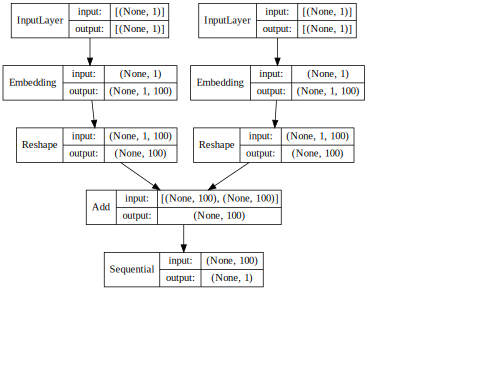

In [ ]:
# build skip-gram architecture
embed_size = 100

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform",input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform", input_length=1))
context_model.add(Reshape((embed_size,)))
merged_output = add([word_model.output, context_model.output])  

model_combined = Sequential()
model_combined.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

final_model = Model([word_model.input, context_model.input], model_combined(merged_output))

final_model.compile(loss="binary_crossentropy", optimizer="Adam")

final_model.summary()
# visualize model structure
SVG(model_to_dot(final_model, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg')) 

In [ ]:
for epoch in range(1, 51):
     loss = 0
     for i, elem in enumerate(skip_grams):
         pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
         pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
         labels = np.array(elem[1], dtype='int32')
         X = [pair_first_elem, pair_second_elem]
         Y = labels
         if i % 10000 == 0:
             print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
         loss += final_model.train_on_batch(X,Y)  
     print('Epoch:', epoch, 'Loss:', loss) 

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 0.6934731602668762
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 0.69076007604599
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 0.6878949403762817
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 0.6849474906921387
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 0.6819416880607605
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 6 Loss: 0.6788902878761292
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 7 Loss: 0.675801694393158
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 8 Loss: 0.6726817488670349
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 9 Loss: 0.6695350408554077
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 10 Loss: 0.6663652658462524
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 11 Loss: 0.6631755828857422
Processed 0 (skip_firs

In [ ]:

word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                    for search_term in ['alaska','death','doctor','rock','play','india','fox','dance',
                                       'king','woman','queen','kingdom','money','state','ball','policy',
                                       'run','hard','live','god','size','distance','cold','wrote',
                                       'write','madrid','time','clock','sings','population']}
similar_words

(5922, 5922)


{'alaska': ['everything', 'labels', 'rhinestone', 'plan', 'sensory'],
 'death': ['formed', 'unfortunate', 'dropped', 'knight', 'winter'],
 'doctor': ['ackley', 'textbook', 'deck', 'cousin', 'febuary'],
 'rock': ['1948', 'coached', '50s', 'meets', 'gravity'],
 'play': ['voted', 'volcanic', 'clarita', 'channel', 'spelling'],
 'india': ['captain', 'craigieburn', 'hub', 'loud', 'urdu'],
 'fox': ['aniston', 'element', '90', 'guinevere', 'east'],
 'dance': ['slave', 'older', 'johnny', 'vehicle', 'keith'],
 'king': ['michael', 'dwarf', 'busiest', 'childs', 'hansel'],
 'woman': ['naa', 'sleep', 'bbc', 'n', 'period'],
 'queen': ['flight', 'print', 'flame', 'mars', 'webs'],
 'kingdom': ['nevada', 'spokesperson', 'fleetwood', 'singer', 'oracle'],
 'money': ['parent', 'plan', 'braves', 'corral', 'government'],
 'state': ['black', 'pounds', 'butch', 'hero', 'models'],
 'ball': ['mother', 'threshold', 'travelling', 'alternative', 'sub'],
 'policy': ['disgust', 'measurement', '2009', 'queenston', 'im

In [ ]:
words = []
for k, v in word2id.items():
    words.append(k)
    

In [ ]:
tsne = TSNE(n_components=3, perplexity=5, learning_rate=200)
embeddings_3d = tsne.fit_transform(distance_matrix)

In [ ]:
# Create a trace for the scatter plot
trace = go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.5,
        color='blue'
    ),
    text=words,
    hoverinfo='text'
)

# Create a layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

# Create a figure and plot the trace
fig = go.Figure(data=[trace], layout=layout)
fig.show()

# Skip-Gram: Arabic Embeddings

In [ ]:
skip_gram_ar = df['Arabic'].tolist()
len(skip_gram_ar)

5463

In [ ]:
with open("skip_gram_ar.txt", "w") as file:
    for sentence2 in skip_gram_ar:
        file.write(sentence2 + "\n")

In [ ]:
corpus_root = "./" 
wordlists = PlaintextCorpusReader(corpus_root, "skip_gram_ar.txt")
sentences2 = wordlists.sents()
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
     tokens = wpt.tokenize(doc)
     # filter stopwords out of document
     filtered_tokens = [token for token in tokens if token not in stop_words_ar]
     # re-create document from filtered tokens
     doc = ' '.join(filtered_tokens)
     return doc
normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_AR = [[word.lower() for word in sent if word not in remove_terms] for sent in sentences2]
norm_AR = [' '.join(tok_sent) for tok_sent in norm_AR]
norm_AR = filter(None, normalize_corpus(norm_AR))
norm_AR = [tok_sent for tok_sent in norm_AR if len(tok_sent.split()) > 2]
#Initializing the tokenizer
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_AR)
word2id = tokenizer.word_index
#making a dictionary
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_AR]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 9423
Vocabulary Sample: [('عدد', 1), ('المتحدة', 2), ('تم', 3), ('الولايات', 4), ('دور', 5), ('فى', 6), ('لعب', 7), ('العالم', 8), ('غنى', 9), ('فاز', 10)]


In [ ]:
 # generate skip-grams
skip_grams = [skipgrams(wid, vocabulary_size=vocab_size, window_size=3) for wid in wids]
 # view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(20):
     print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
           id2word[pairs[i][0]], pairs[i][0], 
           id2word[pairs[i][1]], pairs[i][1], 
           labels[i])) 

(الهند (32), تخلص (8258)) -> 1
(خرجت (301), الطماطم (7870)) -> 0
(المجال (7983), يفوز (1137)) -> 0
(يخرج (141), بطل (629)) -> 1
(الأمريكية (41), إديث (4029)) -> 0
(الكرة (352), للحصول (571)) -> 0
(متوسط (107), الإعلان (2126)) -> 0
(بدأت (149), الى (138)) -> 1
(تمشي (2805), غنى (9)) -> 1
(غنى (9), تروض (5692)) -> 0
(هارد (1454), اتس (456)) -> 1
(أيام (331), فاكهة (5475)) -> 1
(إتس (2567), أولويز (5735)) -> 1
(نو (459), عملية (1869)) -> 0
(كاليفورنيا (183), متابعين (6395)) -> 0
(عدد (1), التنانين (6595)) -> 0
(فارغاس (9284), المقدس (156)) -> 1
(مختلفين (1792), قائمة (187)) -> 1
(الرئيسية (177), المواد (1388)) -> 1
(للمحترفين (42), درجات (3035)) -> 1


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_13_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 embedding_14_input (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 embedding_13 (Embedding)       (None, 1, 100)       942300      ['embedding_13_input[0][0]']     
                                                                                            

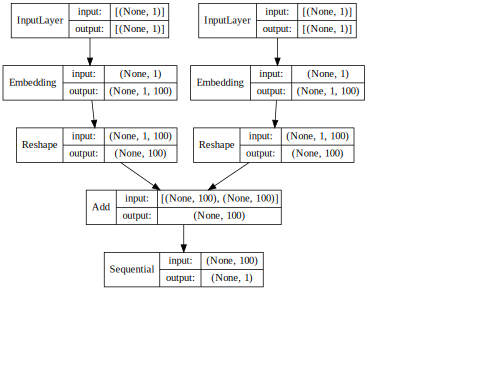

In [ ]:
# build skip-gram architecture
embed_size = 100

word_model = Sequential()
word_model.add(Embedding(vocab_size, embed_size, embeddings_initializer="glorot_uniform",input_length=1))
word_model.add(Reshape((embed_size, )))

context_model = Sequential()
context_model.add(Embedding(vocab_size, embed_size,embeddings_initializer="glorot_uniform", input_length=1))
context_model.add(Reshape((embed_size,)))
merged_output = add([word_model.output, context_model.output])  

model_combined = Sequential()
model_combined.add(Dense(1, kernel_initializer="glorot_uniform", activation="sigmoid"))

final_model = Model([word_model.input, context_model.input], model_combined(merged_output))

final_model.compile(loss="binary_crossentropy", optimizer="Adam")

final_model.summary()
# visualize model structure
SVG(model_to_dot(final_model, show_shapes=True, show_layer_names=False, rankdir='TB').create(prog='dot', format='svg')) 

In [ ]:
for epoch in range(1, 51):
     loss = 0
     for i, elem in enumerate(skip_grams):
         pair_first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
         pair_second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
         labels = np.array(elem[1], dtype='int32')
         X = [pair_first_elem, pair_second_elem]
         Y = labels
         if i % 10000 == 0:
             print('Processed {} (skip_first, skip_second, relevance) pairs'.format(i))
         loss += final_model.train_on_batch(X,Y)  
     print('Epoch:', epoch, 'Loss:', loss) 

Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 1 Loss: 0.6936176419258118
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 2 Loss: 0.6916666030883789
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 3 Loss: 0.6895672678947449
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 4 Loss: 0.6873795986175537
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 5 Loss: 0.6851258277893066
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 6 Loss: 0.6828182339668274
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 7 Loss: 0.6804647445678711
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 8 Loss: 0.6780710816383362
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 9 Loss: 0.6756418347358704
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 10 Loss: 0.6731804013252258
Processed 0 (skip_first, skip_second, relevance) pairs
Epoch: 11 Loss: 0.6706900000572205
Processed 0 (skip_f

In [ ]:
word_embed_layer = word_model.layers[0]
weights = word_embed_layer.get_weights()[0][1:]
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# create a dictionary of similar Arabic words for a list of Arabic search terms
id2word_arabic = {v: k for k, v in word2id.items()}  # create a mapping of Arabic word IDs to words
similar_words_arabic = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['الغواصات','النساء','أغنية','شرق','الشارع']}


print(similar_words_arabic)

(9422, 9422)
{'الغواصات': ['انسجام', 'تيد', 'كواي', 'مولودية', 'لاسلكي'], 'النساء': ['الأمان', 'وور', 'تينيسي', 'غرفين', 'ميجان'], 'أغنية': ['الحادي', 'المصبوب', '30', 'والاس', 'الفايكنج'], 'شرق': ['وجدنا', 'رسمت', 'السوبر', 'لشركة', 'هندي'], 'الشارع': ['الأوليمبية', 'ميتشل', 'بالحرف', 'الرابع', 'أسرع']}


In [ ]:
words_ar = []
for k, v in word2id.items():
    words_ar.append(k)

In [ ]:
tsne = TSNE(n_components=3, perplexity=5, learning_rate=200)
embeddings_3d = tsne.fit_transform(distance_matrix)

In [ ]:

trace = go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.5,
        color='blue'
    ),
    text=words_ar,
    hoverinfo='text'
)

# Create a layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

# Create a figure and plot the trace
fig = go.Figure(data=[trace], layout=layout)
fig.show()

#CBOW English Embeddings#

In [ ]:
corpus_root = "./"  
wordlists = PlaintextCorpusReader(corpus_root, "skip_gram_eng.txt")
sentences = wordlists.sents()
#adding the criterion for removal
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
     # lower case and remove special characters\whitespaces
     doc = re.sub(r'[^a-zA-Z\s]', '', doc,re.I|re.A)
     doc = doc.lower()
     doc = doc.strip()
     # tokenize document
     tokens = wpt.tokenize(doc)
     # filter stopwords out of document
     filtered_tokens = [token for token in tokens if token not in stop_words]
     # re-create document from filtered tokens
     doc = ' '.join(filtered_tokens)
     return doc
normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_English = [[word.lower() for word in sent if word not in remove_terms] for sent in sentences]
norm_English = [' '.join(tok_sent) for tok_sent in norm_English]
norm_English = filter(None, normalize_corpus(norm_English))
norm_English = [tok_sent for tok_sent in norm_English if len(tok_sent.split()) > 2]
#Initializing the tokenizer
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_English)
word2id = tokenizer.word_index
#making a dictionary
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
#creating the context , ta2reeban....
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_English]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 5923
Vocabulary Sample: [('many', 1), ('first', 2), ('world', 3), ('song', 4), ('come', 5), ('sings', 6), ('played', 7), ('last', 8), ('plays', 9), ('time', 10)]


In [ ]:
def precompute_context_word_pairs(corpus, window_size):
    context_length = window_size*2
    context_words = []
    label_word = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):         
            start = index - window_size
            end = index + window_size + 1
            context = [words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index]
            context_words.append(context)
            label_word.append(word)
    return context_words, label_word


def generate_context_word_pairs(context_words, label_word, vocab_size):
    for i in range(len(context_words)):
        x = pad_sequences([context_words[i]], maxlen=len(context_words[i]))
        y = np_utils.to_categorical([label_word[i]], vocab_size)
        yield (x, y)
        

# Precompute context and label arrays
context_words, label_word = precompute_context_word_pairs(corpus=wids, window_size=2)

# Test generator using precomputed context and label arrays
i = 0
for x, y in generate_context_word_pairs(context_words, label_word, vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1


Context (X): ['sunshine', 'band'] -> Target (Y): kc
Context (X): ['kc', 'band', 'king'] -> Target (Y): sunshine
Context (X): ['kc', 'sunshine', 'king', 'queen'] -> Target (Y): band
Context (X): ['sunshine', 'band', 'queen', 'india'] -> Target (Y): king
Context (X): ['band', 'king', 'india', 'phoenix'] -> Target (Y): queen
Context (X): ['king', 'queen', 'phoenix', 'sky'] -> Target (Y): india
Context (X): ['queen', 'india', 'sky', 'harbor'] -> Target (Y): phoenix
Context (X): ['india', 'phoenix', 'harbor', 'international'] -> Target (Y): sky
Context (X): ['phoenix', 'sky', 'international', 'airport'] -> Target (Y): harbor
Context (X): ['sky', 'harbor', 'airport', 'paget'] -> Target (Y): international
Context (X): ['harbor', 'international', 'paget', 'brewster'] -> Target (Y): airport


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 4, 100)            592300    
                                                                 
 lambda_3 (Lambda)           (None, 100)               0         
                                                                 
 dense_9 (Dense)             (None, 5923)              598223    
                                                                 
Total params: 1,190,523
Trainable params: 1,190,523
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 4, 100)            592300    
                                                                 
 lambda_3 (Lamb

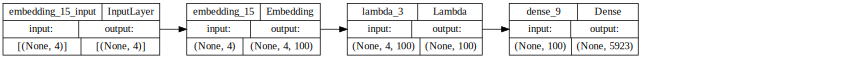

In [ ]:
# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=2*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='Adam')

# view model summary
print(cbow.summary())

# view model summary
print(cbow.summary())
svg = SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=True, rankdir='LR',expand_nested=True,).create(prog='dot', format='svg'))
display_svg(svg)


In [ ]:
# Precompute context and label arrays
context_words, label_word = precompute_context_word_pairs(corpus=wids, window_size=2)

# Train the neural network
batch_size = 128
num_epochs = 50
steps_per_epoch = len(context_words) // batch_size

for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    epoch_loss = 0
    for step in range(steps_per_epoch):
        # Get the next batch of context and label pairs
        batch_context_words = context_words[step*batch_size:(step+1)*batch_size]
        batch_label_word = label_word[step*batch_size:(step+1)*batch_size]
        
        # Pad the context sequences and convert the labels to one-hot encoding
        batch_x = pad_sequences(batch_context_words, maxlen=2*2)
        batch_y = np_utils.to_categorical(batch_label_word, num_classes=vocab_size)
        
        # Train the model on the batch
        batch_loss = cbow.train_on_batch(batch_x, batch_y)
        epoch_loss += batch_loss
        
        if (step+1) % 1000 == 0:
            print("  Batch {}/{} - loss: {:.4f}".format(step+1, steps_per_epoch, batch_loss))
    
    print("Epoch {} loss: {:.4f}\n".format(epoch+1, epoch_loss/steps_per_epoch))


Epoch 1/50
Epoch 1 loss: 8.5813

Epoch 2/50
Epoch 2 loss: 7.8267

Epoch 3/50
Epoch 3 loss: 7.5114

Epoch 4/50
Epoch 4 loss: 7.3962

Epoch 5/50
Epoch 5 loss: 7.2786

Epoch 6/50
Epoch 6 loss: 7.1445

Epoch 7/50
Epoch 7 loss: 6.9898

Epoch 8/50
Epoch 8 loss: 6.8134

Epoch 9/50
Epoch 9 loss: 6.6164

Epoch 10/50
Epoch 10 loss: 6.4005

Epoch 11/50
Epoch 11 loss: 6.1679

Epoch 12/50
Epoch 12 loss: 5.9223

Epoch 13/50
Epoch 13 loss: 5.6681

Epoch 14/50
Epoch 14 loss: 5.4091

Epoch 15/50
Epoch 15 loss: 5.1484

Epoch 16/50
Epoch 16 loss: 4.8887

Epoch 17/50
Epoch 17 loss: 4.6321

Epoch 18/50
Epoch 18 loss: 4.3805

Epoch 19/50
Epoch 19 loss: 4.1355

Epoch 20/50
Epoch 20 loss: 3.8982

Epoch 21/50
Epoch 21 loss: 3.6694

Epoch 22/50
Epoch 22 loss: 3.4500

Epoch 23/50
Epoch 23 loss: 3.2404

Epoch 24/50
Epoch 24 loss: 3.0407

Epoch 25/50
Epoch 25 loss: 2.8510

Epoch 26/50
Epoch 26 loss: 2.6711

Epoch 27/50
Epoch 27 loss: 2.5007

Epoch 28/50
Epoch 28 loss: 2.3395

Epoch 29/50
Epoch 29 loss: 2.1873

Epo

In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[:])

(5922, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
many,-0.244119,0.537439,-1.448756,-0.226095,0.121035,-1.793641,1.247963,0.805961,1.605207,-1.529298,...,-0.422913,-1.101305,-1.395490,0.660913,-1.429730,-1.680143,1.811062,-0.899557,0.357606,0.798175
first,0.911971,-0.296744,0.708489,0.843079,1.579040,2.451562,-0.887630,1.449472,-1.216516,0.594138,...,-0.045298,0.643603,1.873343,0.499972,-0.327772,-0.409167,1.891375,-1.165507,1.520853,0.784489
world,0.509634,1.015223,-0.030679,-0.667280,1.003900,0.286843,-1.405582,0.645509,1.142421,-0.065039,...,0.454497,-1.223523,0.477580,0.765202,-2.426790,0.861800,-1.316272,1.440934,-1.137453,-0.406132
song,0.506613,-0.127788,1.691731,0.585486,-0.899013,1.605441,-0.470565,-0.497945,1.475915,-0.924251,...,0.264003,-0.728933,1.240298,1.144856,1.480840,0.495291,-0.289225,-0.157372,0.881701,-1.374833
come,-0.620400,-0.726247,-0.671303,0.593718,-0.158928,-1.513635,-1.504539,0.440320,0.658654,0.616021,...,1.617744,0.779092,-0.793932,-1.777687,-1.466431,-0.805576,-1.643882,-0.449537,0.581616,0.145422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
whered,0.006106,-0.019714,0.041482,-0.000558,-0.014450,-0.038564,-0.022325,0.018613,-0.039418,0.027967,...,-0.009128,-0.007698,-0.029273,-0.010440,-0.016202,0.036635,-0.044449,0.015621,-0.041444,0.030891
bernadette,0.006376,0.025895,-0.035100,0.020731,-0.010110,-0.028756,-0.049010,-0.045357,-0.016871,0.035703,...,0.000423,-0.022397,0.039472,0.004275,-0.022130,-0.035256,0.021486,-0.005791,-0.041195,0.049921
nancy,-0.047735,0.008673,0.024482,0.004555,-0.003787,-0.010179,0.030645,-0.048495,0.042816,-0.025995,...,-0.031266,0.009530,-0.015074,0.037276,0.041328,0.030760,0.042202,0.023514,-0.019495,-0.002238
arbuckle,-0.047664,-0.023147,-0.042176,-0.006207,-0.027510,0.031593,-0.014631,-0.027075,0.048132,-0.046701,...,-0.001491,-0.009690,0.025231,-0.007356,-0.024936,0.026650,-0.018512,-0.003880,0.013317,0.028587


In [ ]:
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['alaska','death','doctor','rock','play','india','fox','dance',
                                       'king','woman','queen','kingdom','money','state','ball','policy',
                                       'run','hard','live','god','size','distance','cold','wrote',
                                       'write','madrid']}

similar_words

(5922, 5922)


{'alaska': ['drinks', 'apart', 'nome', 'describes', 'greenland'],
 'death': ['pink', 'nancy', 'sherlock', 'kite', 'gandalf'],
 'doctor': ['bengals', 'colin', 'venezuela', 'enemy', 'thors'],
 'rock': ['tears', 'glad', 'marlins', 'load', 'n'],
 'play': ['graduate', 'lois', 'torino', 'lorax', 'swept'],
 'india': ['cranberries', 'beginnings', 'pakistan', 'enemies', 'orbisons'],
 'fox': ['bernadette', 'reduced', 'sherlock', 'boyfriend', 'arbuckle'],
 'dance': ['moms', 'whiskey', 'drinks', '51', 'sherlock'],
 'king': ['dreams', 'sleeps', 'starsky', 'mufasa', 'travolta'],
 'woman': ['moose', 'assamese', 'ips', 'brawl', '1867'],
 'queen': ['hms', 'vargas', 'jar', 'totos', 'spiders'],
 'kingdom': ['matthew', 'emirates', 'bernadette', 'boyfriend', 'pink'],
 'money': ['bank', 'pays', 'agt', 'electric', 'lewes'],
 'state': ['punjab', 'albany', 'hyatt', 'yorktown', 'bend'],
 'ball': ['nintendo', 'masks', 'boyfriend', 'ups', 'arbuckle'],
 'policy': ['decision', 'density', 'vijayanagar', 'punjab', 'r

In [ ]:
words = []
for k, v in word2id.items():
    words.append(k)
    

In [ ]:
tsne = TSNE(n_components=3, perplexity=5, learning_rate=200)
embeddings_3d = tsne.fit_transform(distance_matrix)

In [ ]:
trace = go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.5,
        color='blue'
    ),
    text=words,
    hoverinfo='text'
)

# Create a layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

# Create a figure and plot the trace
fig = go.Figure(data=[trace], layout=layout)
fig.show()

#CBOW: Arabic Embeddings#

In [ ]:
corpus_root = "./" 
wordlists = PlaintextCorpusReader(corpus_root, "skip_gram_ar.txt")
#reading the corpus like we would read a corpus file built-in NLTK
sentences2 = wordlists.sents()
#adding the criterion for removal
remove_terms = punctuation + '0123456789'
wpt = nltk.WordPunctTokenizer()
def normalize_document(doc):
     tokens = wpt.tokenize(doc)
     # filter stopwords out of document
     filtered_tokens = [token for token in tokens if token not in stop_words_ar]
     # re-create document from filtered tokens
     doc = ' '.join(filtered_tokens)
     return doc
normalize_corpus = np.vectorize(normalize_document)

In [ ]:
norm_AR = [[word.lower() for word in sent if word not in remove_terms] for sent in sentences2]
norm_AR = [' '.join(tok_sent) for tok_sent in norm_AR]
norm_AR = filter(None, normalize_corpus(norm_AR))
norm_AR = [tok_sent for tok_sent in norm_AR if len(tok_sent.split()) > 2]
#Initializing the tokenizer
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(norm_AR)
word2id = tokenizer.word_index
#making a dictionary
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id) + 1
#creating the context , ta2reeban....
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in norm_AR]
print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 9423
Vocabulary Sample: [('عدد', 1), ('المتحدة', 2), ('تم', 3), ('الولايات', 4), ('دور', 5), ('فى', 6), ('لعب', 7), ('العالم', 8), ('غنى', 9), ('فاز', 10)]


In [ ]:
def precompute_context_word_pairs(corpus, window_size):
    context_length = window_size*2
    context_words = []
    label_word = []
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):         
            start = index - window_size
            end = index + window_size + 1
            context = [words[i] for i in range(start, end) if 0 <= i < sentence_length and i != index]
            context_words.append(context)
            label_word.append(word)
    return context_words, label_word


def generate_context_word_pairs(context_words, label_word, vocab_size):
    for i in range(len(context_words)):
        x = pad_sequences([context_words[i]], maxlen=len(context_words[i]))
        y = np_utils.to_categorical([label_word[i]], vocab_size)
        yield (x, y)
        

# Precompute context and label arrays
context_words, label_word = precompute_context_word_pairs(corpus=wids, window_size=2)

# Test generator using precomputed context and label arrays
i = 0
for x, y in generate_context_word_pairs(context_words, label_word, vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1


Context (X): ['سي', 'آند'] -> Target (Y): كيه
Context (X): ['كيه', 'آند', 'فرقة'] -> Target (Y): سي
Context (X): ['كيه', 'سي', 'فرقة', 'الشمس'] -> Target (Y): آند
Context (X): ['سي', 'آند', 'الشمس', 'ملكنا'] -> Target (Y): فرقة
Context (X): ['آند', 'فرقة', 'ملكنا', 'وملكتنا'] -> Target (Y): الشمس
Context (X): ['فرقة', 'الشمس', 'وملكتنا', 'عبر'] -> Target (Y): ملكنا
Context (X): ['الشمس', 'ملكنا', 'عبر', 'الهند'] -> Target (Y): وملكتنا
Context (X): ['ملكنا', 'وملكتنا', 'الهند', 'مطار'] -> Target (Y): عبر
Context (X): ['وملكتنا', 'عبر', 'مطار', 'فينيكس'] -> Target (Y): الهند
Context (X): ['عبر', 'الهند', 'فينيكس', 'سكاي'] -> Target (Y): مطار
Context (X): ['الهند', 'مطار', 'سكاي', 'هاربر'] -> Target (Y): فينيكس


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 4, 100)            942300    
                                                                 
 lambda_4 (Lambda)           (None, 100)               0         
                                                                 
 dense_10 (Dense)            (None, 9423)              951723    
                                                                 
Total params: 1,894,023
Trainable params: 1,894,023
Non-trainable params: 0
_________________________________________________________________
None


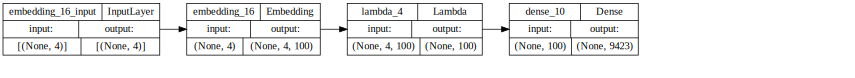

In [ ]:
# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=2*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='Adam')

# view model summary
print(cbow.summary())

svg = SVG(model_to_dot(cbow, show_shapes=True, show_layer_names=True, rankdir='LR',expand_nested=True,).create(prog='dot', format='svg'))
display_svg(svg)


In [ ]:
context_words, label_word = precompute_context_word_pairs(corpus=wids, window_size=2)

# Train the neural network
batch_size = 128
num_epochs = 50
steps_per_epoch = len(context_words) // batch_size

for epoch in range(num_epochs):
    print("Epoch {}/{}".format(epoch+1, num_epochs))
    epoch_loss = 0
    for step in range(steps_per_epoch):
        # Get the next batch of context and label pairs
        batch_context_words = context_words[step*batch_size:(step+1)*batch_size]
        batch_label_word = label_word[step*batch_size:(step+1)*batch_size]
        
        # Pad the context sequences and convert the labels to one-hot encoding
        batch_x = pad_sequences(batch_context_words, maxlen=2*2)
        batch_y = np_utils.to_categorical(batch_label_word, num_classes=vocab_size)
        
        # Train the model on the batch
        batch_loss = cbow.train_on_batch(batch_x, batch_y)
        epoch_loss += batch_loss
        
        if (step+1) % 1000 == 0:
            print("  Batch {}/{} - loss: {:.4f}".format(step+1, steps_per_epoch, batch_loss))
    
    print("Epoch {} loss: {:.4f}\n".format(epoch+1, epoch_loss/steps_per_epoch))


Epoch 1/50
Epoch 1 loss: 9.0672

Epoch 2/50
Epoch 2 loss: 8.3846

Epoch 3/50
Epoch 3 loss: 7.9966

Epoch 4/50
Epoch 4 loss: 7.7865

Epoch 5/50
Epoch 5 loss: 7.5727

Epoch 6/50
Epoch 6 loss: 7.3505

Epoch 7/50
Epoch 7 loss: 7.1179

Epoch 8/50
Epoch 8 loss: 6.8731

Epoch 9/50
Epoch 9 loss: 6.6150

Epoch 10/50
Epoch 10 loss: 6.3429

Epoch 11/50
Epoch 11 loss: 6.0568

Epoch 12/50
Epoch 12 loss: 5.7588

Epoch 13/50
Epoch 13 loss: 5.4527

Epoch 14/50
Epoch 14 loss: 5.1424

Epoch 15/50
Epoch 15 loss: 4.8308

Epoch 16/50
Epoch 16 loss: 4.5207

Epoch 17/50
Epoch 17 loss: 4.2145

Epoch 18/50
Epoch 18 loss: 3.9148

Epoch 19/50
Epoch 19 loss: 3.6244

Epoch 20/50
Epoch 20 loss: 3.3457

Epoch 21/50
Epoch 21 loss: 3.0806

Epoch 22/50
Epoch 22 loss: 2.8303

Epoch 23/50
Epoch 23 loss: 2.5952

Epoch 24/50
Epoch 24 loss: 2.3752

Epoch 25/50
Epoch 25 loss: 2.1702

Epoch 26/50
Epoch 26 loss: 1.9794

Epoch 27/50
Epoch 27 loss: 1.8025

Epoch 28/50
Epoch 28 loss: 1.6386

Epoch 29/50
Epoch 29 loss: 1.4872

Epo

In [ ]:
weights = cbow.get_weights()[0]
weights = weights[1:]
print(weights.shape)

pd.DataFrame(weights, index=list(id2word.values())[:])

(9422, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
عدد,0.011674,0.337261,1.550489,-2.946902,1.719071,-1.680503,1.716009,-0.312747,1.433256,-1.521523,...,-1.724407,-2.161378,-1.553069,-1.817886,1.475426,1.419260,1.081929,-1.755103,1.783607,-2.506213
المتحدة,0.120397,1.464553,-1.981679,-1.099750,-0.442001,0.841799,1.338828,0.882993,-1.478691,-1.222438,...,-0.415296,0.852930,0.262729,1.585214,-0.470066,-1.245130,2.066512,1.531380,0.932859,-0.044136
تم,0.453987,0.619387,-1.617230,-1.520029,-1.584484,0.086871,-1.793237,-1.955383,0.610490,-1.140020,...,-0.180869,-0.747254,-0.446609,-0.678265,0.058501,0.449047,-0.605442,-2.389169,1.912502,0.115889
الولايات,0.358310,-0.339278,0.069533,2.444062,-1.066940,0.587096,1.537012,-1.154606,-0.371999,-1.412997,...,-0.878075,-1.895600,1.102174,0.255866,1.609747,-1.588937,1.650250,-1.001565,0.511088,-0.398785
دور,2.120419,0.273963,-2.097324,-2.078774,0.087069,1.675900,1.413195,2.144605,2.001688,0.391827,...,-0.700288,0.282461,-0.659960,1.938742,1.505029,-0.369689,0.143041,1.844659,-2.212336,1.248434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ويرد,0.040796,-0.042314,-0.045812,0.037825,0.044768,-0.049146,0.043430,0.010203,0.026233,0.036191,...,-0.005984,-0.038108,-0.013572,-0.012750,-0.016805,0.038404,0.025724,0.045314,-0.021246,-0.008078
برناديت,0.035192,0.029074,-0.035716,-0.009417,0.025575,0.018557,-0.037370,-0.035719,-0.048747,-0.038527,...,-0.008001,0.009251,-0.017715,-0.030243,0.039655,0.031669,0.035190,0.042663,-0.036868,-0.016765
نانسي,0.023916,0.002667,0.028976,0.044107,0.016202,0.027173,0.021275,0.047912,0.008464,0.009888,...,0.018989,-0.030702,0.039580,0.000799,0.007438,-0.045859,0.024827,0.023780,0.016870,-0.037494
آرباكل,-0.014271,0.045684,0.038802,0.041054,-0.001606,0.012113,-0.001624,-0.030020,-0.044989,0.028836,...,-0.024306,-0.004677,0.013448,0.017048,-0.010127,-0.048282,0.044415,-0.047124,-0.038042,0.041050


In [ ]:
# compute pairwise distance matrix
distance_matrix = euclidean_distances(weights)
print(distance_matrix.shape)

# view contextually similar words
similar_words = {search_term: [id2word[idx] for idx in distance_matrix[word2id[search_term]-1].argsort()[1:6]+1] 
                   for search_term in ['الغواصات','النساء','أغنية','شرق','الشارع']}

similar_words

(9422, 9422)


{'الغواصات': ['جوازات', 'كحيوانات', 'تتصرف', 'الانتروبيا', 'تلد'],
 'النساء': ['لورين', '1913', 'فيدرشين', 'الأكل', 'اموال'],
 'أغنية': ['نزال', 'ناديني', 'لايتس', 'سني', 'صني'],
 'شرق': ['مواطنو', 'السند', 'وجاءت', 'المتصدع', 'لكريش'],
 'الشارع': ['معجزة', 'ويرد', 'نانسي', 'البالغين', 'برناديت']}

In [ ]:
words = []
for k, v in word2id.items():
    words.append(k)
    

In [ ]:
tsne = TSNE(n_components=3, perplexity=5, learning_rate=200)
embeddings_3d = tsne.fit_transform(distance_matrix)

In [ ]:
trace = go.Scatter3d(
    x=embeddings_3d[:, 0],
    y=embeddings_3d[:, 1],
    z=embeddings_3d[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        opacity=0.5,
        color='blue'
    ),
    text=words,
    hoverinfo='text'
)

# Create a layout for the plot
layout = go.Layout(
    margin=dict(l=0, r=0, b=0, t=0),
    scene=dict(
        xaxis=dict(title='Dimension 1'),
        yaxis=dict(title='Dimension 2'),
        zaxis=dict(title='Dimension 3')
    )
)

# Create a figure and plot the trace
fig = go.Figure(data=[trace], layout=layout)
fig.show()